In [2]:
# !pip install netCDF4
import xarray as xr
import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd
# from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from dataretrieval import nwis as nwis
import datetime
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
cb_centerlines = gpd.read_file('C:/Users/dego/Documents/local_files/RSSA/Platte_centerlines_masks/vector_centerlines/s2_platte_centerlines.shp').to_crs(3857)
merit_centerlines = gpd.read_file('C:/Users/dego/Documents/local_files/RSSA/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [4]:
Qarray = xr.open_dataset('C:/Users/dego/Documents/local_files/RSSA/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc', engine='netcdf4')

In [5]:
gage_list = ['06764880', '06775900', '06775500', '06770200', '06767970', '06768000',
             '06784000', '06781900', '06785000', '06790500', '06800500', '06793000',
             '06800000', '06777495', '06786000', '06799350', '06799315', '06799000',
             '06797500', '06785500', '06710247', '06711565', '06714215', '06721000',
             '06759500', '06620000', '06680500', '06630000', '06674500', '06635000',
             '06670500', '06657000', '06652000']




In [6]:
gages = nwis.get_info(sites=gage_list)[0][['site_no', 'geometry']]
gages

,site_no,geometry
0,06620000,POINT (-106.33919 40.93664)
1,06630000,POINT (-107.0576 41.87217)
2,06635000,POINT (-106.51314 42.00967)
3,06652000,POINT (-105.15921 42.65248)
4,06657000,POINT (-104.62802 42.24101)
5,06670500,POINT (-104.53835 42.20051)
6,06674500,POINT (-104.05334 41.98857)
7,06680500,POINT (-103.67556 41.84994)
8,06710247,POINT (-105.01498 39.63249)
9,06711565,POINT (-105.00415 39.66499)


In [7]:
gage_COMID = gpd.sjoin_nearest(gages.to_crs(3857), merit_centerlines, max_distance=1000)[['site_no', 'COMID']]

IFMHA

In [8]:
gage_nums = [int(site_no) for site_no in gage_list]
ifmha = pd.read_csv(r'C:\Users\dego\Documents\local_files\RSSA\IFMHA\IFMHA.csv')

ifmha = ifmha.loc[ifmha.site_no.isin(gage_nums)]

ifmha.measurement_dt = pd.to_datetime(ifmha.measurement_dt)
ifmha = ifmha.loc[(ifmha.measurement_dt >= datetime.datetime(2018, 1, 1)) & (ifmha.measurement_dt <= datetime.datetime(2024, 12, 31))]

ifmha['date'] = ifmha.measurement_dt.dt.date
ifmha.chan_width = ifmha.chan_width / 3.28
ifmha.site_no = ifmha.apply(lambda x: f'0{x.site_no}', axis=1)


ifmha = ifmha[['site_no', 'date', 'chan_width']]

C:\Users\dego\AppData\Local\Temp\ipykernel_95808\2328685556.py:2: DtypeWarning: Columns (4,8,37) have mixed types. Specify dtype option on import or set low_memory=False.
  ifmha = pd.read_csv(r'C:\Users\dego\Documents\local_files\RSSA\IFMHA\IFMHA.csv')


In [9]:
width_dfs = []
for gage in (gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['chan_width'] = isw.width_ft / 3.28
isw = isw[['date', 'chan_width', 'site_no']]

C:\Users\dego\AppData\Local\Temp\ipykernel_95808\4196513999.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  isw = pd.concat(width_dfs)


In [10]:
all_isw = pd.concat([isw, ifmha])
all_isw = all_isw.loc[(all_isw.date >= datetime.date(2017, 12, 31)) & (all_isw.date <= datetime.date(2025, 1, 31))]
all_isw.date = pd.to_datetime(all_isw.date).dt.date
all_isw

,date,chan_width,site_no
0,2021-05-26,15.853659,06775900
4,2019-08-21,14.024390,06775900
5,2020-09-16,15.243902,06775900
7,2019-09-04,16.463415,06775900
9,2021-11-29,20.121951,06775900
...,...,...,...
1711697,2022-04-27,66.768293,06800500
1711698,2022-06-10,71.646341,06800500
1711699,2022-07-18,61.890244,06800500
1711700,2022-08-15,54.878049,06800500


In [11]:
Q = nwis.get_dv(sites=gage_list, start='2018-01-01', end='2024-12-31', parameterCd='00060')[0]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q = Q.rename(columns={'00060_Mean': 'Q_cms', '00060_Mean_cd': 'Q_cd'}).reset_index()

Q['date'] = pd.to_datetime(Q.datetime).dt.date
Q = Q.loc[Q.Q_cd == 'A']
Q = Q[['site_no', 'Q_cms', 'date']].set_index(['site_no', 'date'])
Q['Q_percentile'] = Q.groupby('site_no')['Q_cms'].rank(pct=True)
bins = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

all_allbins = []

Q['Q_percentile_bin'] = Q.groupby('site_no')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=bins, labels=False)
)

Q

Q_cms  Q_percentile  Q_percentile_bin
site_no  date                                                 
06620000 2018-03-24   9.323401      0.591856               5.0
         2018-03-25  12.128923      0.648990               6.0
         2018-03-26  12.355632      0.655303               6.0
         2018-03-27  11.023717      0.630682               6.0
         2018-03-28   9.748480      0.602273               6.0
...                        ...           ...               ...
06800500 2024-12-27  30.038921      0.274314               2.0
         2024-12-28  32.306010      0.312968               3.0
         2024-12-29  33.439554      0.327681               3.0
         2024-12-30  35.990028      0.363092               3.0
         2024-12-31  36.556801      0.369825               3.0

[67804 rows x 3 columns]

In [12]:
Q_isw = pd.merge(Q, all_isw, how='outer', on=['site_no', 'date'])
Q_isw

,site_no,date,Q_cms,Q_percentile,Q_percentile_bin,chan_width
0,06620000,2018-01-17,NaN,NaN,NaN,35.670732
1,06620000,2018-03-13,NaN,NaN,NaN,51.524390
2,06620000,2018-03-24,9.323401,0.591856,5.0,NaN
3,06620000,2018-03-25,12.128923,0.648990,6.0,NaN
4,06620000,2018-03-26,12.355632,0.655303,6.0,NaN
...,...,...,...,...,...,...
68123,06800500,2024-12-28,32.306010,0.312968,3.0,NaN
68124,06800500,2024-12-29,33.439554,0.327681,3.0,NaN
68125,06800500,2024-12-30,35.990028,0.363092,3.0,NaN
68126,06800500,2024-12-31,36.556801,0.369825,3.0,NaN


In [13]:
bad_gages = ['06799350', '06799000', '06770200']
# , '06652000', '06775900']

C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1640906510.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logQ'] = np.log10(df.Q_cms)
C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1640906510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_isw'] = np.log10(df.chan_width)
C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1640906510.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Text(0.02, 0.5, '$log_{10}(w)$')

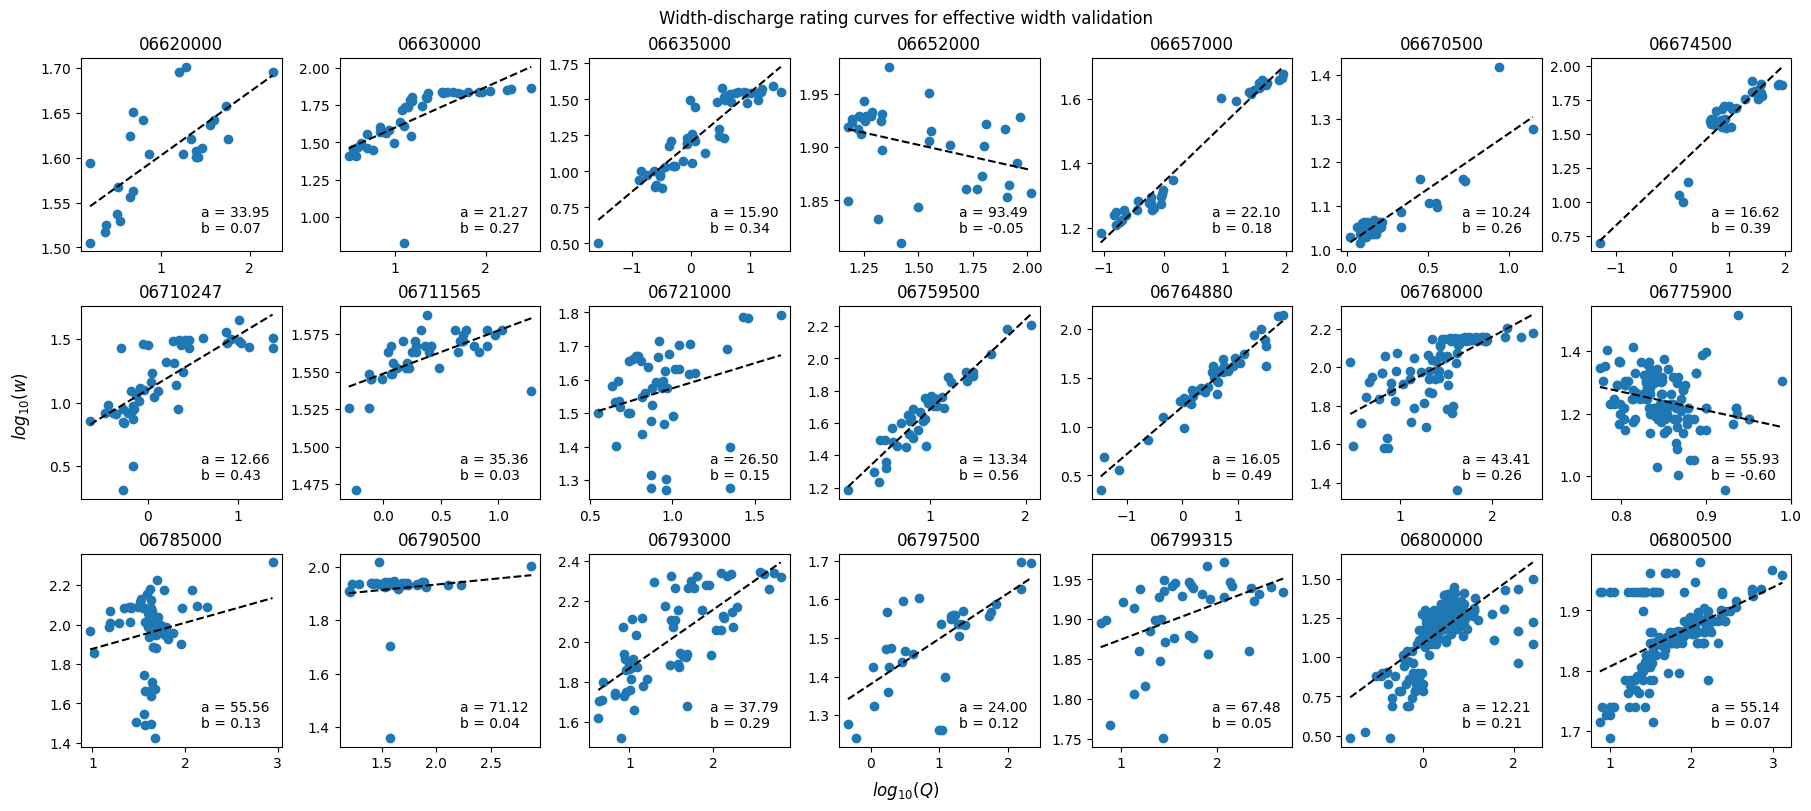

In [15]:
rc_slopes = []
rc_intercepts = []
r2s = []
site_nos = []
n_meas = []
fig, axs = plt.subplots(3, 7, figsize=(18, 8), constrained_layout=True)

p = 0


for sn, df in Q_isw.groupby('site_no'):

    df = df.loc[(df.Q_cms > 0) & (df.chan_width > 0)]

    
    
    if len(df) > 5 and not sn in (bad_gages):

        df['logQ'] = np.log10(df.Q_cms)
        df['log_isw'] = np.log10(df.chan_width)

        slope, intercept, r, pval, _ = linregress(df.logQ, df.log_isw)

        ax = axs.flatten()[p]

        ax.scatter(df.logQ, df.log_isw, zorder=0)
        qaxis = np.linspace(min(df.logQ), max(df.logQ))
        ax.plot(qaxis, qaxis * slope + intercept, c='black', zorder=1, ls='--')

        rc_slopes.append(slope)
        rc_intercepts.append(intercept)
        r2s.append(r ** 2)
        site_nos.append(sn)
        n_meas.append(len(df))

        ax.set_title(sn)
        ax.text(0.6, 0.1, f'a = {10 ** intercept:.2f}\nb = {slope:.2f}', transform=ax.transAxes)
        
        p += 1

    else:
        rc_slopes.append(None)
        rc_intercepts.append(None)
        r2s.append(None)
        site_nos.append(sn)
        n_meas.append(len(df))


fig.suptitle('Width-discharge rating curves for effective width validation')
fig.supxlabel(r'$log_{10}(Q)$')
fig.supylabel(r'$log_{10}(w)$')

In [16]:
rating_curve_parms = pd.DataFrame({'site_no': site_nos, 'loga': rc_intercepts, 'b': rc_slopes, 'r2': r2s, 'n_meas': n_meas}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,loga,b,r2,n_meas,a
site_no,,,,,
06620000,1.530836,0.071459,0.505187,26,33.949712
06630000,1.327849,0.271679,0.468132,41,21.273984
06635000,1.201460,0.344146,0.838188,49,15.902304
06652000,1.970773,-0.045704,0.117457,35,93.491595
06657000,1.344484,0.181462,0.972364,35,22.104678
06670500,1.010392,0.255494,0.779363,47,10.242182
06674500,1.220528,0.394849,0.852579,38,16.616064
06680500,NaN,NaN,NaN,0,NaN
06710247,1.102370,0.426956,0.543195,48,12.658149


In [17]:
regional_b = (rating_curve_parms.loc[rating_curve_parms['r2'] > 0]['b'].mean())
regional_a = (rating_curve_parms.loc[rating_curve_parms['r2'] > 0]['a'].mean())


for row in rating_curve_parms.loc[rating_curve_parms.r2.isna()].iterrows():
    sn = row[0]
    rating_curve_parms.at[sn, 'a'] = regional_a
    rating_curve_parms.at[sn, 'b'] = regional_b

# rating_curve_parms

print(regional_a)
print(regional_b)

35.244599919613805
0.17602827201081545


In [18]:
Q_isw

,site_no,date,Q_cms,Q_percentile,Q_percentile_bin,chan_width
0,06620000,2018-01-17,NaN,NaN,NaN,35.670732
1,06620000,2018-03-13,NaN,NaN,NaN,51.524390
2,06620000,2018-03-24,9.323401,0.591856,5.0,NaN
3,06620000,2018-03-25,12.128923,0.648990,6.0,NaN
4,06620000,2018-03-26,12.355632,0.655303,6.0,NaN
...,...,...,...,...,...,...
68123,06800500,2024-12-28,32.306010,0.312968,3.0,NaN
68124,06800500,2024-12-29,33.439554,0.327681,3.0,NaN
68125,06800500,2024-12-30,35.990028,0.363092,3.0,NaN
68126,06800500,2024-12-31,36.556801,0.369825,3.0,NaN


In [19]:
# paired_Qw['predicted_width'] = rating_curve_parms.loc[x.index.get_level_values(0), 'b'] * 
# paired_Qw = paired_Qw.reset_index()
Q_isw['predicted_width'] = Q_isw.apply(lambda x: rating_curve_parms.loc[x.site_no, 'a'] * (x.Q_cms ** (rating_curve_parms.loc[x.site_no, 'b'])), axis=1)
Q_isw

,site_no,date,Q_cms,Q_percentile,Q_percentile_bin,chan_width,predicted_width
0,06620000,2018-01-17,NaN,NaN,NaN,35.670732,NaN
1,06620000,2018-03-13,NaN,NaN,NaN,51.524390,NaN
2,06620000,2018-03-24,9.323401,0.591856,5.0,NaN,39.821839
3,06620000,2018-03-25,12.128923,0.648990,6.0,NaN,40.577510
4,06620000,2018-03-26,12.355632,0.655303,6.0,NaN,40.631244
...,...,...,...,...,...,...,...
68123,06800500,2024-12-28,32.306010,0.312968,3.0,NaN,69.257266
68124,06800500,2024-12-29,33.439554,0.327681,3.0,NaN,69.414051
68125,06800500,2024-12-30,35.990028,0.363092,3.0,NaN,69.749402
68126,06800500,2024-12-31,36.556801,0.369825,3.0,NaN,69.820900


rmse = 26.85268544686422
bias = 4.957892241208038


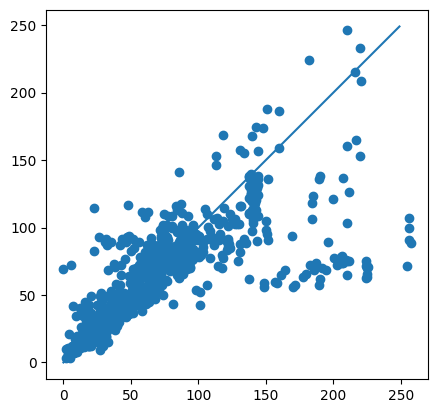

In [21]:
fig, ax = plt.subplots()
df = Q_isw.loc[(Q_isw.chan_width >= 0) & (Q_isw.predicted_width >= 0)]
ax.scatter(df.chan_width, df.predicted_width)
ax.plot(range(0, 250), range(0, 250))
ax.set_aspect('equal')
print('rmse =', np.sqrt(mean_squared_error(df.chan_width, df.predicted_width)))
print('bias =', (df.chan_width - df.predicted_width).mean())

In [ ]:
ews = []

files = glob.glob('C:/Users/dego/Documents/local_files/RSSA/effwidth_exports/all_sites/*20250928.csv')

for f in files:
    ews.append(pd.read_csv(f))

files = glob.glob('C:/Users/dego/Documents/local_files/RSSA/effwidth_exports/gage_sites/*g*_2025092*.csv')

for f in files:
    ews.append(pd.read_csv(f))

ew_df = pd.concat(ews)
ew_df['date'] = ew_df.apply(lambda x: datetime.date(int(x.img_id[10:14]), int(x.img_id[14:16]), int(x.img_id[16:18])), axis=1)

In [ ]:
ew_df

In [22]:
# ew_pts1 = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\platte_pts_10000m.shp")[['iindex', 'geometry']]
# ew_circles1 = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\buffs_3x_width_20250903.shp")[['iindex', 'geometry']]

# ew_pts2 = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\gage_sites\gage_points_20250918.shp")[['iindex', 'geometry']]
# ew_circles2 = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\gage_sites\gage_circles_3x_20250918.shp")[['iindex', 'geometry']]

# ew_pts3 = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\gage_sites\gage_points_extra.shp")[['iindex', 'geometry']]
# ew_circles3 = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\gage_sites\gage_circles_3x_extra.shp")[['iindex', 'geometry']]


# ew_pts = pd.concat([ew_pts1, ew_pts2, ew_pts3]).to_crs(3857)
# ew_circles = pd.concat([ew_circles1, ew_circles2, ew_circles3]).to_crs(3857)
# ew_pts = ew_pts.loc[(ew_pts.iindex.isin(ew_circles.iindex)) & (ew_pts.iindex != 30618)]


ew_pts = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\points_20251010.shp")[['iindex', 'geometry']]
ew_circles = gpd.read_file(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\circles_3x_20251010.shp")[['iindex', 'geometry']].to_crs(3857)

cb_centerlines = gpd.read_file('C:/Users/dego/Documents/local_files/RSSA/Platte_centerlines_masks/vector_centerlines/s2_platte_centerlines.shp')\
    .set_crs(4326, allow_override=True)\
    .to_crs(3857)

ew_circles['riv_length'] = ew_circles.apply(lambda x: gpd.sjoin(cb_centerlines, gpd.GeoDataFrame(geometry=[x.geometry], crs=3857)).length.sum(), axis=1)

ew_pts = pd.merge(ew_pts, ew_circles[['iindex', 'riv_length']])
ew_pts = ew_pts.to_crs(3857).sjoin_nearest(merit_centerlines, distance_col='distance')

In [23]:
ews = []

for y in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    ews.append(pd.read_csv(fr"C:\Users\dego\Documents\local_files\RSSA\effwidth_results\effwidths_{y}.csv"))

ew_df = pd.concat(ews)
ew_gdf = gpd.GeoDataFrame(ew_df, geometry=gpd.points_from_xy(ew_df.x, ew_df.y, crs=4326)).to_crs(3857)
ew_gdf

,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,x,y,geometry
0,S2A_14TNM_20181107_0_L2A,48196,42,42,9,0,0,0,23,1,-98.717171,41.808625,POINT (-10989145.211 5132355.383)
1,S2A_14TNM_20181107_0_L2A,105223,41,41,7,0,0,0,22,1,-98.851377,41.917231,POINT (-11004084.906 5148589.099)
2,S2A_14TNM_20181107_0_L2A,61517,40,40,2,7,0,0,22,0,-98.650066,41.757421,POINT (-10981675.115 5124711.303)
3,S2A_14TNM_20181107_0_L2A,19705,41,41,17,0,0,0,23,4,-98.727142,42.335936,POINT (-10990255.127 5211434.634)
4,S2A_14TNM_20181107_0_L2A,57705,38,38,10,2,0,1,22,3,-98.709443,41.795872,POINT (-10988284.976 5130450.948)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134880,S2A_13TGG_20240711_0_L2A,117366,-999,-999,-999,-999,-999,-999,-999,-999,-102.508508,41.444990,POINT (-11411194.947 5078200.804)
134881,S2A_13TGG_20240711_0_L2A,108544,-999,-999,-999,-999,-999,-999,-999,-999,-102.438799,41.413188,POINT (-11403434.963 5073479.099)
134882,S2A_13TGG_20240711_0_L2A,108793,-999,-999,-999,-999,-999,-999,-999,-999,-102.411492,41.404385,POINT (-11400395.102 5072172.631)
134883,S2A_13TGG_20240711_0_L2A,117554,-999,-999,-999,-999,-999,-999,-999,-999,-102.486141,41.442114,POINT (-11408705.081 5077773.69)


In [24]:
ew_gdf = gpd.sjoin_nearest(ew_gdf, ew_pts.drop('index_right', axis=1))

In [25]:
ew_gdf.loc[(ew_gdf.n_valid == ew_gdf.n_pixels) & (ew_gdf.n_pixels > 0)]

,img_id,iindex_left,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,...,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,distance
0,S2A_14TNM_20181107_0_L2A,48196,42,42,9,0,0,0,23,1,...,3,15.2,0.001272,74023856,2,74023984,74026465,0,0,71.057939
1,S2A_14TNM_20181107_0_L2A,105223,41,41,7,0,0,0,22,1,...,3,25.1,0.001264,74023984,2,74024579,74024717,0,0,72.541614
2,S2A_14TNM_20181107_0_L2A,61517,40,40,2,7,0,0,22,0,...,3,2.0,0.000794,74023797,2,74023856,74026027,0,0,136.107371
3,S2A_14TNM_20181107_0_L2A,19705,41,41,17,0,0,0,23,4,...,2,34.6,0.001483,74023835,2,74024211,74027238,0,0,39.900221
4,S2A_14TNM_20181107_0_L2A,57705,38,38,10,2,0,1,22,3,...,3,15.2,0.001272,74023856,2,74023984,74026465,0,0,95.611298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134872,S2B_13TDH_20240121_0_L2A,106191,3151,3151,303,0,3075,0,182,6,...,5,4.5,0.001160,74022678,2,74022680,74028469,0,0,15.751454
134873,S2B_13TDH_20240121_0_L2A,61148,3701,3701,0,0,3621,0,197,0,...,5,9.0,0.001000,74022668,2,74022670,74028098,0,0,14.476303
134874,S2B_13TDH_20240121_0_L2A,56939,3711,3711,502,0,3475,0,198,18,...,5,4.1,0.001493,74022673,2,74022675,74024143,0,0,23.863513
134875,S2B_13TDH_20240121_0_L2A,57394,3768,3768,612,0,0,0,198,14,...,5,36.9,0.003423,74022662,2,74022664,74027847,0,0,31.964114


In [26]:
ew_gdf['sat_width_m'] = ew_gdf.n_river * 100 / ew_gdf.riv_length
ew_gdf['fraction_cloud'] = ew_gdf.n_cloud / ew_gdf.n_pixels
ew_gdf['fraction_snow'] = ew_gdf.n_snow / ew_gdf.n_pixels
ew_gdf['fraction_edgeriver'] = ew_gdf.n_edgeriver / ew_gdf.n_edge

ew_gdf

,img_id,iindex_left,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,...,maxup,up1,up2,up3,up4,distance,sat_width_m,fraction_cloud,fraction_snow,fraction_edgeriver
0,S2A_14TNM_20181107_0_L2A,48196,42,42,9,0,0,0,23,1,...,2,74023984,74026465,0,0,71.057939,8.758751,0.000000,0.0,0.043478
1,S2A_14TNM_20181107_0_L2A,105223,41,41,7,0,0,0,22,1,...,2,74024579,74024717,0,0,72.541614,7.191853,0.000000,0.0,0.045455
2,S2A_14TNM_20181107_0_L2A,61517,40,40,2,7,0,0,22,0,...,2,74023856,74026027,0,0,136.107371,2.389519,0.175000,0.0,0.000000
3,S2A_14TNM_20181107_0_L2A,19705,41,41,17,0,0,0,23,4,...,2,74024211,74027238,0,0,39.900221,15.234967,0.000000,0.0,0.173913
4,S2A_14TNM_20181107_0_L2A,57705,38,38,10,2,0,1,22,3,...,2,74023984,74026465,0,0,95.611298,12.769011,0.052632,0.0,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134880,S2A_13TGG_20240711_0_L2A,117366,-999,-999,-999,-999,-999,-999,-999,-999,...,2,74029289,74030721,0,0,239.170209,-115.039476,1.000000,1.0,1.000000
134881,S2A_13TGG_20240711_0_L2A,108544,-999,-999,-999,-999,-999,-999,-999,-999,...,2,74029281,74036671,0,0,316.602787,-115.345223,1.000000,1.0,1.000000
134882,S2A_13TGG_20240711_0_L2A,108793,-999,-999,-999,-999,-999,-999,-999,-999,...,2,74029281,74036671,0,0,70.325544,-99.187203,1.000000,1.0,1.000000
134883,S2A_13TGG_20240711_0_L2A,117554,-999,-999,-999,-999,-999,-999,-999,-999,...,2,74029289,74030721,0,0,57.355992,-101.474539,1.000000,1.0,1.000000


In [55]:
ew_gdf.columns

Index(['img_id', 'iindex_left', 'n_pixels', 'n_valid', 'n_river', 'n_cloud',
       'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver', 'x', 'y', 'geometry',
       'index_right', 'iindex_right', 'riv_length', 'COMID', 'lengthkm',
       'lengthdir', 'sinuosity', 'slope', 'uparea', 'order', 'strmDrop_t',
       'slope_taud', 'NextDownID', 'maxup', 'up1', 'up2', 'up3', 'up4',
       'distance', 'sat_width_m', 'fraction_cloud', 'fraction_snow',
       'fraction_edgeriver'],
      dtype='object')

In [52]:
gage_COMID

,site_no,COMID
0,06620000,74030717
1,06630000,74022829
2,06635000,74026624
3,06652000,74022670
4,06657000,74022653
5,06670500,74022745
6,06674500,74022645
7,06680500,74022523
8,06710247,74038444
9,06711565,74038438


In [69]:
gage_COMID_ew = pd.merge(gage_COMID, ew_gdf, how='right', on='COMID')
gage_COMID_ew = gage_COMID_ew.loc[gage_COMID_ew.site_no.str.len() > 0]

In [70]:
for g in gage_list:
    df = gage_COMID_ew.loc[gage_COMID_ew.site_no == g]
    print(g, ': ', df.geometry.nunique())

06764880 :  2
06775900 :  13
06775500 :  2
06770200 :  6
06767970 :  1
06768000 :  0
06784000 :  10
06781900 :  7
06785000 :  2
06790500 :  1
06800500 :  7
06793000 :  6
06800000 :  23
06777495 :  1
06786000 :  3
06799350 :  3
06799315 :  4
06799000 :  4
06797500 :  4
06785500 :  6
06710247 :  1
06711565 :  4
06714215 :  4
06721000 :  5
06759500 :  4
06620000 :  1
06680500 :  10
06630000 :  11
06674500 :  15
06635000 :  0
06670500 :  1
06657000 :  4
06652000 :  2


In [71]:
gage_COMID_ew_filtered = gage_COMID_ew.copy()
print(len(gage_COMID_ew_filtered))
gage_COMID_ew_filtered = gage_COMID_ew_filtered.loc[gage_COMID_ew_filtered.fraction_cloud < 0.2]
# print(len(gage_COMID_ew_filtered))
gage_COMID_ew_filtered = gage_COMID_ew_filtered.loc[gage_COMID_ew_filtered.fraction_snow < 0.2]
# print(len(gage_COMID_ew_filtered))
gage_COMID_ew_filtered = gage_COMID_ew_filtered.loc[((gage_COMID_ew_filtered.n_cloud - gage_COMID_ew_filtered.n_cloudriver) / gage_COMID_ew_filtered.n_valid) < 0.2]
print(len(gage_COMID_ew_filtered))
gage_COMID_ew_filtered = gage_COMID_ew_filtered.loc[gage_COMID_ew_filtered.fraction_edgeriver < 0.4]
print(len(gage_COMID_ew_filtered))
gage_COMID_ew_filtered = gage_COMID_ew_filtered.loc[gage_COMID_ew_filtered.n_edgeriver < gage_COMID_ew_filtered.n_river]
print(len(gage_COMID_ew_filtered))

83697
60851
60283
58924


In [72]:
gage_COMID_ew_filtered['date'] = gage_COMID_ew_filtered.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)

In [77]:
Q_isw

,site_no,date,Q_cms,Q_percentile,Q_percentile_bin,chan_width,predicted_width
0,06620000,2018-01-17,NaN,NaN,NaN,35.670732,NaN
1,06620000,2018-03-13,NaN,NaN,NaN,51.524390,NaN
2,06620000,2018-03-24,9.323401,0.591856,5.0,NaN,39.821839
3,06620000,2018-03-25,12.128923,0.648990,6.0,NaN,40.577510
4,06620000,2018-03-26,12.355632,0.655303,6.0,NaN,40.631244
...,...,...,...,...,...,...,...
68123,06800500,2024-12-28,32.306010,0.312968,3.0,NaN,69.257266
68124,06800500,2024-12-29,33.439554,0.327681,3.0,NaN,69.414051
68125,06800500,2024-12-30,35.990028,0.363092,3.0,NaN,69.749402
68126,06800500,2024-12-31,36.556801,0.369825,3.0,NaN,69.820900


In [ ]:
Qw_decilebins = pd.merge(gage_COMID_ew_filtered, Q_isw[['site_no', 'date', 'Q_cms']], how='left', on=['site_no', 'date'])
Qw_decilebins['Q_percentile'] = Qw_decilebins.groupby('site_no')['Q_cms'].rank(pct=True)
Qw_decilebins['decile'] = Qw_decilebins.groupby('site_no')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], labels=False)
)
Qw_decilebins = Qw_decilebins.loc[Qw_decilebins.decile >= 0]

array([ 6.,  1., nan,  7.,  2.,  9.,  3.,  0.,  5.,  8.,  4.])

In [112]:
orders = Qw_decilebins.sort_values('NewSO').NewSO.unique()
orders

array([ 6,  7,  8,  9, 10, 11, 12])

In [93]:
from scipy.stats import lognorm

In [90]:
decile_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [111]:
Qw_decilebins.NewSO

0        9
1        9
2        9
2        9
3        9
        ..
59133    9
59134    9
59134    9
59135    9
59136    9
Name: NewSO, Length: 63637, dtype: int64

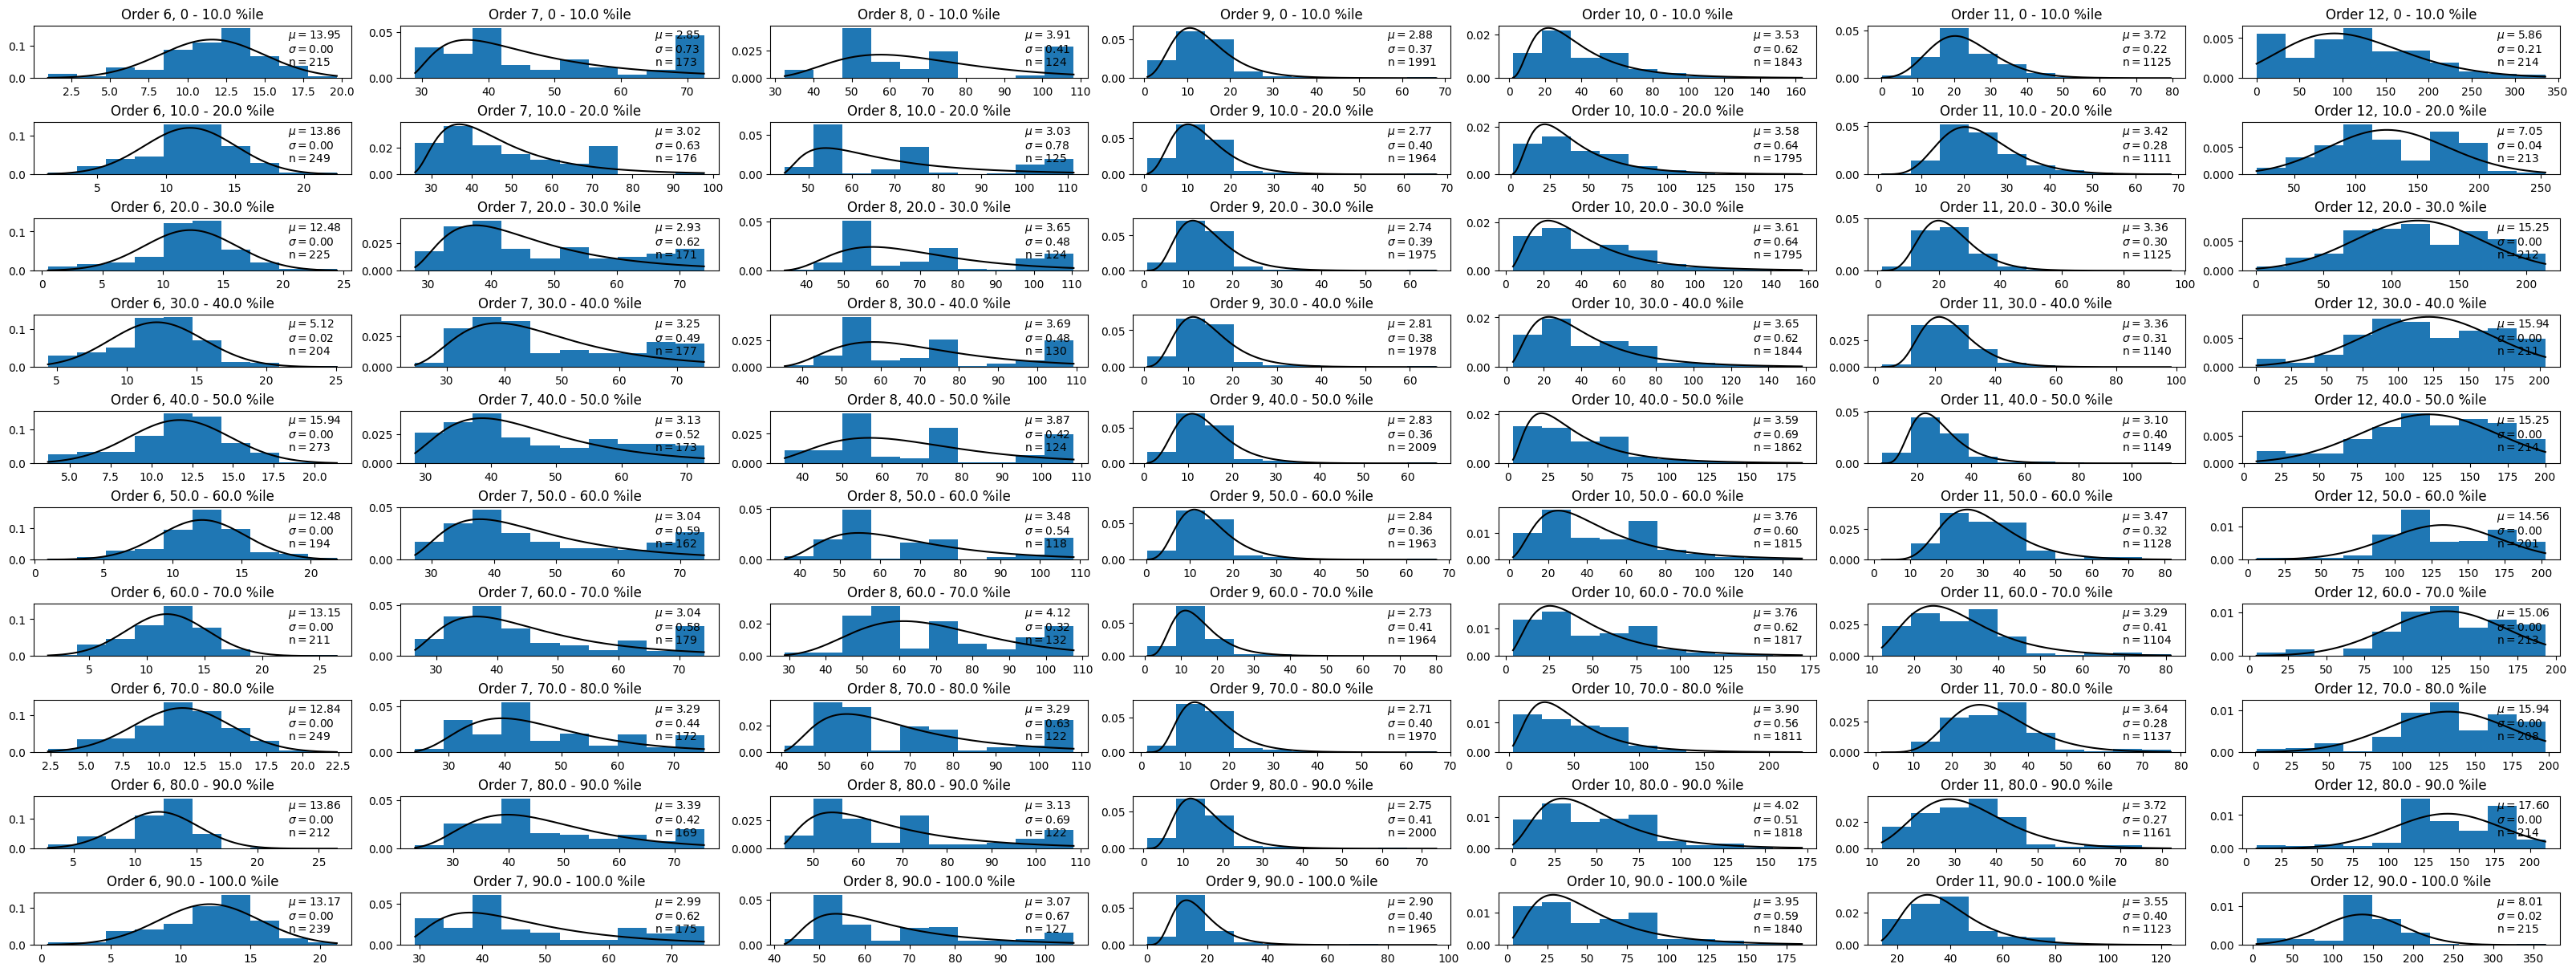

In [113]:
sigmas = []
mus = []
os = []
qs = []

fig, axs = plt.subplots(10, 7, figsize=(32, 12), constrained_layout=True)

for q in range(len(decile_bins) - 1):
    for o in range(len(orders)):
        order = orders[o]
        ax = axs[q, o]
        df = Qw_decilebins.loc[(Qw_decilebins.NewSO == order) & (Qw_decilebins.decile == q)]

        x = np.linspace(min(df.sat_width_m), max(df.sat_width_m), 1000)

        shape, loc, scale = lognorm.fit(df.sat_width_m)
        sigma = shape
        mu = np.log(scale)
        pdf_fitted = lognorm.pdf(x, shape, scale=scale, loc=loc)

        sigmas.append(sigma)
        mus.append(mu)
        os.append(order)
        qs.append(q)


        ax.hist(df.sat_width_m, density=True)
        ax.plot(x, pdf_fitted, color='black')

        param_label = '\n'.join((
            r'$\mu=%.2f$' % (mu, ),
            r'$\sigma=%.2f$' % (sigma, ),
            r'$\mathrm{n}=%.0f$' % (len(df) )))
        ax.text(0.8, 0.95, param_label, transform=ax.transAxes, verticalalignment='top')
        ax.set_title(f'Order {order}, {100 * decile_bins[q]} - {100 * decile_bins[q + 1]} %ile')
        # bins smaller

        # try same x axis and count y axis

In [109]:
Qw_decilebins = gpd.sjoin_nearest(gpd.GeoDataFrame(Qw_decilebins.drop('index_right', axis=1)), cb_centerlines[['geometry', 'NewSO']])
Qw_decilebins

,site_no,COMID,img_id,iindex_left,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,...,sat_width_m,fraction_cloud,fraction_snow,fraction_edgeriver,date,Q_cms,Q_percentile,decile,index_right,NewSO
0,06797500,74023501,S2A_14TNM_20181107_0_L2A,11535,519,519,106,97,0,35,...,27.309812,0.186898,0.0,0.171053,2018-11-07,9.493433,0.645614,6.0,233028,9
1,06711565,74038438,S2B_13SDD_20180810_0_L2A,38087,73,73,22,0,0,0,...,17.186584,0.000000,0.0,0.200000,2018-08-10,1.096704,0.136782,1.0,4399,9
2,06710247,74038444,S2B_13SDD_20180810_0_L2A,38436,164,164,37,28,0,17,...,19.162892,0.170732,0.0,0.136364,2018-08-10,0.606446,0.154255,1.0,4792,9
2,06710247,74038444,S2B_13SDD_20180810_0_L2A,38436,164,164,37,28,0,17,...,19.162892,0.170732,0.0,0.136364,2018-08-10,0.606446,0.154255,1.0,4791,9
3,06714215,74038417,S2A_13TEE_20180716_0_L2A,33809,74,74,22,6,0,2,...,16.112668,0.081081,0.0,0.133333,2018-07-16,NaN,NaN,NaN,2998,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59133,06721000,74030009,S2A_13TEE_20241201_0_L2A,35678,41,41,17,0,0,0,...,18.530768,0.000000,0.0,0.136364,2024-12-01,NaN,NaN,NaN,68435,9
59134,06721000,74030009,S2A_13TEE_20241201_0_L2A,35384,71,71,18,0,0,0,...,15.900653,0.000000,0.0,0.172414,2024-12-01,NaN,NaN,NaN,68033,9
59134,06721000,74030009,S2A_13TEE_20241201_0_L2A,35384,71,71,18,0,0,0,...,15.900653,0.000000,0.0,0.172414,2024-12-01,NaN,NaN,NaN,68032,9
59135,06721000,74030009,S2A_13TEE_20241201_0_L2A,35176,72,72,18,0,0,0,...,14.496479,0.000000,0.0,0.133333,2024-12-01,NaN,NaN,NaN,67834,9


Text(0.02, 0.5, 'Flow percentile')

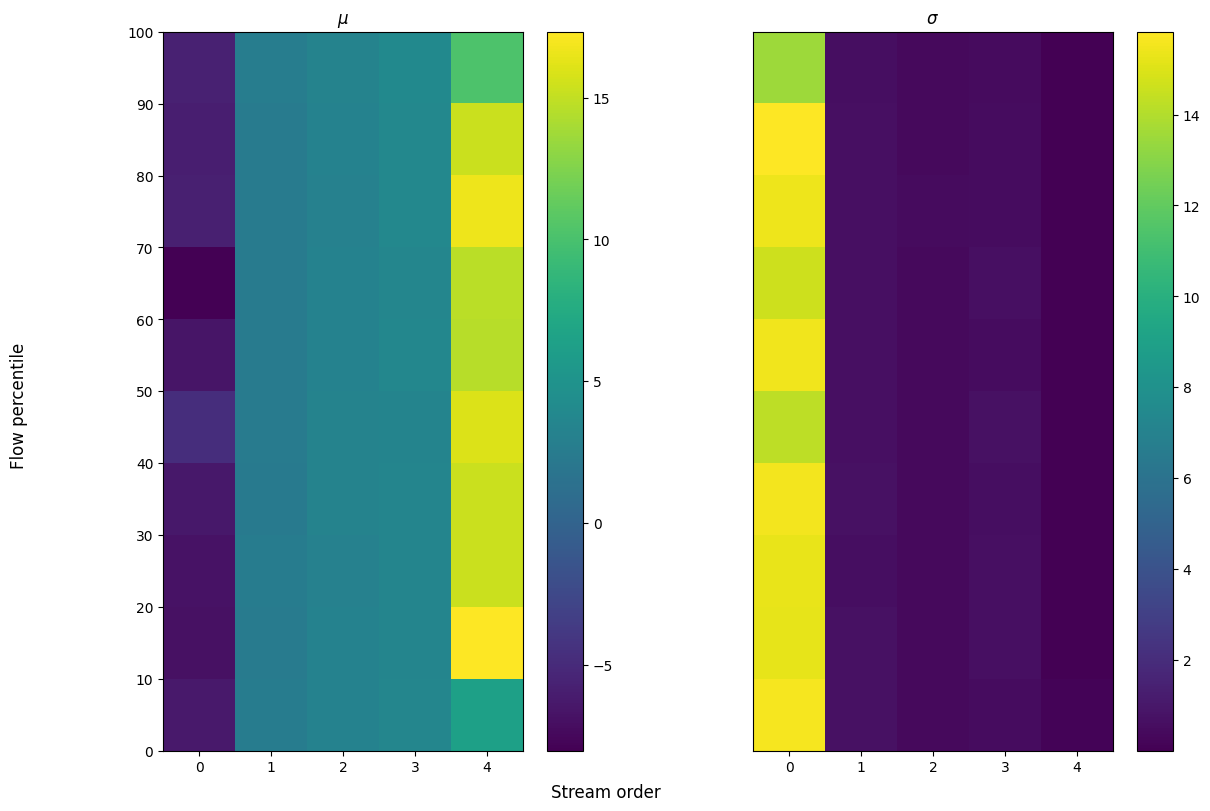

In [ ]:
osarray = np.array(os.copy())

osarray.shape = (10, 7)

os_axis = osarray[1]
os_axis = [int(os_axis[o]) for o in range(len(os_axis))]
qsarray = np.array(qs.copy())
qsarray.shape = (10, 7)
qs_axis = qsarray[:, 1]
qs_axis = [int(decile_bins[d] * 100) for d in range(len(decile_bins))]


musarray = np.array(mus.copy())
musarray.shape = (10, 5)

sigmasarray = np.array(sigmas.copy())
sigmasarray.shape = (10, 5)

fig, (mu_img, sigma_img) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 8))
mshow = mu_img.imshow(np.flip(musarray, axis=0))
# mu_img.set_xticks([0, 1, 2, 3, 4, 5, 6])
# mu_img.set_xticklabels(os_axis)

mu_img.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
mu_img.set_yticklabels(np.flip(qs_axis))
mu_img.set_title(r'$\mu$')

im_ratio = musarray.shape[0]/musarray.shape[1]

plt.colorbar(mshow, orientation="vertical", fraction=0.05*im_ratio, ax=mu_img, pad=0.05)


sshow = sigma_img.imshow(np.flip(sigmasarray, axis=0))
# sigma_img.set_xticks([0, 1, 2, 3, 4, 5, 6])
# sigma_img.set_xticklabels(os_axis)

# fig.set_constrained_layout_pads(w_pad=1./72, h_pad=1./72, wspace=0.01, hspace=0.01)

# sigma_img.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
sigma_img.yaxis.set_visible(False)
sigma_img.set_title(r'$\sigma$')

plt.colorbar(sshow, orientation="vertical", fraction=0.05*im_ratio, ax=sigma_img, pad=0.05)

fig.supxlabel('Stream order')
fig.supylabel('Flow percentile')

In [34]:
gage_COMID_ew_stats = gage_COMID_ew_filtered.groupby(['site_no', 'date']).agg(
    mean_width = ('sat_width_m', lambda x: x.mean()),
    median_width = ('sat_width_m', lambda x: x.median()),
    COMID = ('COMID', lambda x: int(x.mean())),
    range_width = ('sat_width_m', lambda x: x.max() - x.min()),
    max_width = ('sat_width_m', lambda x: x.max()),
    min_width = ('sat_width_m', lambda x: x.min()),
    n_meas = ('sat_width_m', lambda x: x.count())
)
gage_COMID_ew_stats

mean_width  median_width     COMID  range_width  \
site_no  date                                                          
06620000 2018-04-22   21.973879     21.973879  74030717     0.000000   
         2018-04-27   24.117673     24.117673  74030717     0.000000   
         2018-05-17   24.653621     24.653621  74030717     0.000000   
         2018-06-06   23.581724     23.581724  74030717     0.000000   
         2018-06-11   19.294138     19.294138  74030717     0.000000   
...                         ...           ...       ...          ...   
06800500 2024-11-19   51.868351     52.304604  74029691    18.106086   
         2024-12-04   48.648902     48.847553  74029691    15.587368   
         2024-12-09   53.567234     52.661876  74029691    18.184614   
         2024-12-19   50.896336     52.161695  74029691    16.043593   
         2024-12-22   53.374473     55.311247  74029691    19.136240   

                     max_width  min_width  n_meas  
site_no  date                                      
06620000 2018-04-22  21.973879  21.973879       1  
         2018-04-27  24.117673  24.117673       1  
         2018-05-17  24.653621  24.653621       1  
         2018-06-06  23.581724  23.581724       1  
         2018-06-11  19.294138  19.294138       1  
...                        ...        ...     ...  
06800500 2024-11-19  60.822193  42.716107      14  
         2024-12-04  57.746913  42.159545      14  
         2024-12-09  63.247910  45.063296      14  
         2024-12-19  59.455402  43.411809      14  
         2024-12-22  63.555774  44.419534      14  

[9848 rows x 7 columns]

In [35]:
all_joined = pd.merge(gage_COMID_ew_stats, Q_isw, on=['site_no', 'date'], how='outer')
# all_joined = pd.merge(all_joined, Q.reset_index(), on=['site_no', 'date'], how='outer')
all_joined

,site_no,date,mean_width,median_width,COMID,range_width,max_width,min_width,n_meas,Q_cms,Q_percentile,Q_percentile_bin,chan_width,predicted_width
0,06620000,2018-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.670732,NaN
1,06620000,2018-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.524390,NaN
2,06620000,2018-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.323401,0.591856,5.0,NaN,39.821839
3,06620000,2018-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.128923,0.648990,6.0,NaN,40.577510
4,06620000,2018-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.355632,0.655303,6.0,NaN,40.631244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69404,06800500,2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.306010,0.312968,3.0,NaN,69.257266
69405,06800500,2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.439554,0.327681,3.0,NaN,69.414051
69406,06800500,2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.990028,0.363092,3.0,NaN,69.749402
69407,06800500,2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.556801,0.369825,3.0,NaN,69.820900


In [36]:
bins = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
all_joined['isw_percentile'] = all_joined.groupby('site_no')['chan_width'].rank(pct=True)
all_joined['isw_percentile_bin'] = all_joined.groupby('site_no')['isw_percentile'].transform(
    lambda x: pd.cut(x, bins=bins, labels=False)
)

all_joined['Q_percentile'] = all_joined.groupby('site_no')['Q_cms'].rank(pct=True)
all_joined['Q_percentile_bin'] = all_joined.groupby('site_no')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=bins, labels=False)
)
# all_joined

C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1449642739.py:52: RuntimeWarning: Mean of empty slice.
  print('mean rmse =', np.array(rmses).mean())
c:\Users\dego\Documents\GitHub\multitemporal_RSSA\rssa_venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1449642739.py:53: RuntimeWarning: Mean of empty slice.
  print('mean bias =', np.array([abs(b) for b in biases]).mean())
C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1449642739.py:56: RuntimeWarning: Mean of empty slice.
  print('mean rmse 10-90% =', np.array(rmses[1:9]).mean())
C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1449642739.py:57: RuntimeWarning: Mean of empty slice.
  print('mean bias 10-90% =', np.array([abs(b) for b in biases[1:9]]).mean())
C:\Users\dego\AppData\Local\Temp\ipykernel_95808\1449642739.py:58: RuntimeWarning: Mean of empty slice.
  print('mean r2 10-90% =',

mean rmse = nan
mean bias = nan


mean rmse 10-90% = nan
mean bias 10-90% = nan
mean r2 10-90% = nan


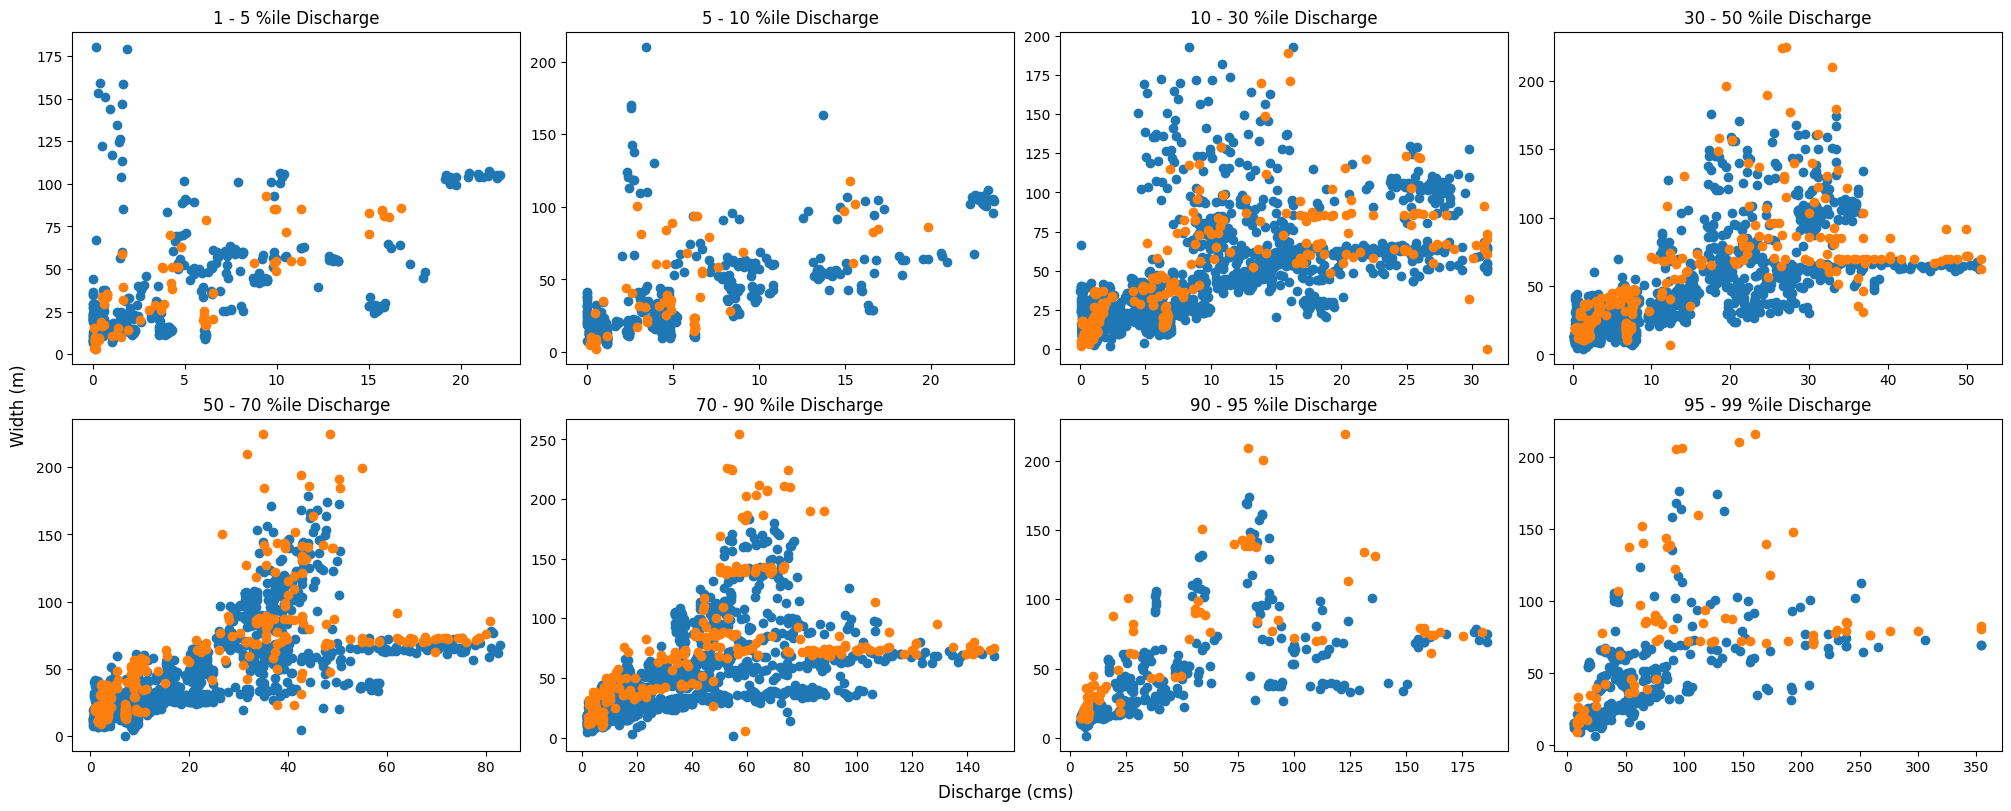

In [37]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8), constrained_layout=True)
# nobridge_wQ = wQ.loc[wQ.index.get_level_values('site_no').isin(nobridge)]
# paired_Qw['color'] = paired_Qw.index.get_level_values('site_no').map(cs)
biases = []
rmses = []
r2s = []

n = 5
g = gage_list[n]
for i in range(len(bins) - 1):

    ax = axs.flatten()[i]
    df = all_joined.loc[all_joined.Q_percentile_bin == i].reset_index()
    df1 = df.loc[(df.Q_cms >= 0) &
                (df.mean_width >= 0)]
    df2 = df.loc[(df.Q_cms >= 0) &
                (df.chan_width >= 0)]
    smalldf = df.loc[(df.site_no == gage_list[3])]
    
    if len(df) > 2:
        upper = max(df.Q_cms.max(), df.mean_width.max())

        # slope, intercept, r, pval, _ = linregress(df.Q_cms, df.mean_width)

        # errors = df.Q_cms - df.mean_width
        # bias = np.mean(errors)
        # mse = mean_squared_error(df.Q_cms, df.mean_width)
        # rmse = np.sqrt(mse)
        # r2 = r2_score(df.Q_cms, df.mean_width)

        ax.scatter(df1.Q_cms, df1.mean_width)
        ax.scatter(df2.Q_cms, df2.chan_width, c='tab:orange')
        waxis = np.linspace(0, upper)
        # ax.plot(waxis, waxis, c='black', ls='--')
        # ax.plot(waxis, waxis * slope + intercept, c='tab:green')
        ax.set_title(f'{int(100 * bins[i])} - {int(100 * bins[i + 1])} %ile Discharge')

        # ax.text(0.1, 0.75, f'n = {len(df)}\nr2 = {r2:.2f}\ny = {slope:.2f}x + {intercept:.2f}\nrmse = {rmse:.2f}\nbias = {bias:.2f}', transform=ax.transAxes)
        # ax.set_aspect('equal')
        # ax.set_xlim(0, upper)
        # ax.set_ylim(0, upper)

        # r2s.append(r2)
        # biases.append(bias)
        # rmses.append(rmse)

fig.supxlabel('Discharge (cms)')
fig.supylabel('Width (m)')
# fig.suptitle(g)


print('mean rmse =', np.array(rmses).mean())
print('mean bias =', np.array([abs(b) for b in biases]).mean())
# print('mean r2 =', np.array(r2s).mean())
print('\n')
print('mean rmse 10-90% =', np.array(rmses[1:9]).mean())
print('mean bias 10-90% =', np.array([abs(b) for b in biases[1:9]]).mean())
print('mean r2 10-90% =', np.array(r2s[1:9]).mean())

In [38]:
all_joined

,site_no,date,mean_width,median_width,COMID,range_width,max_width,min_width,n_meas,Q_cms,Q_percentile,Q_percentile_bin,chan_width,predicted_width,isw_percentile,isw_percentile_bin
0,06620000,2018-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.670732,NaN,0.297297,2.0
1,06620000,2018-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.524390,NaN,1.000000,NaN
2,06620000,2018-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.323401,0.591483,4.0,NaN,39.821839,NaN,NaN
3,06620000,2018-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.128923,0.648580,4.0,NaN,40.577510,NaN,NaN
4,06620000,2018-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.355632,0.654890,4.0,NaN,40.631244,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69404,06800500,2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.306010,0.314237,3.0,NaN,69.257266,NaN,NaN
69405,06800500,2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.439554,0.328864,3.0,NaN,69.414051,NaN,NaN
69406,06800500,2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.990028,0.364700,3.0,NaN,69.749402,NaN,NaN
69407,06800500,2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.556801,0.371282,3.0,NaN,69.820900,NaN,NaN


In [39]:
gage_COMID_ew_stats.mean_width

site_no   date      
06620000  2018-04-22    21.973879
          2018-04-27    24.117673
          2018-05-17    24.653621
          2018-06-06    23.581724
          2018-06-11    19.294138
                          ...    
06800500  2024-11-19    51.868351
          2024-12-04    48.648902
          2024-12-09    53.567234
          2024-12-19    50.896336
          2024-12-22    53.374473
Name: mean_width, Length: 9848, dtype: float64

mean rmse = 23.254571394176622
mean bias = 11.723719453850615
mean r2 = 0.05365558541204439


mean rmse 10-90% = 23.650657093417514
mean bias 10-90% = 12.947234233542602
mean r2 10-90% = 0.03584635539949532


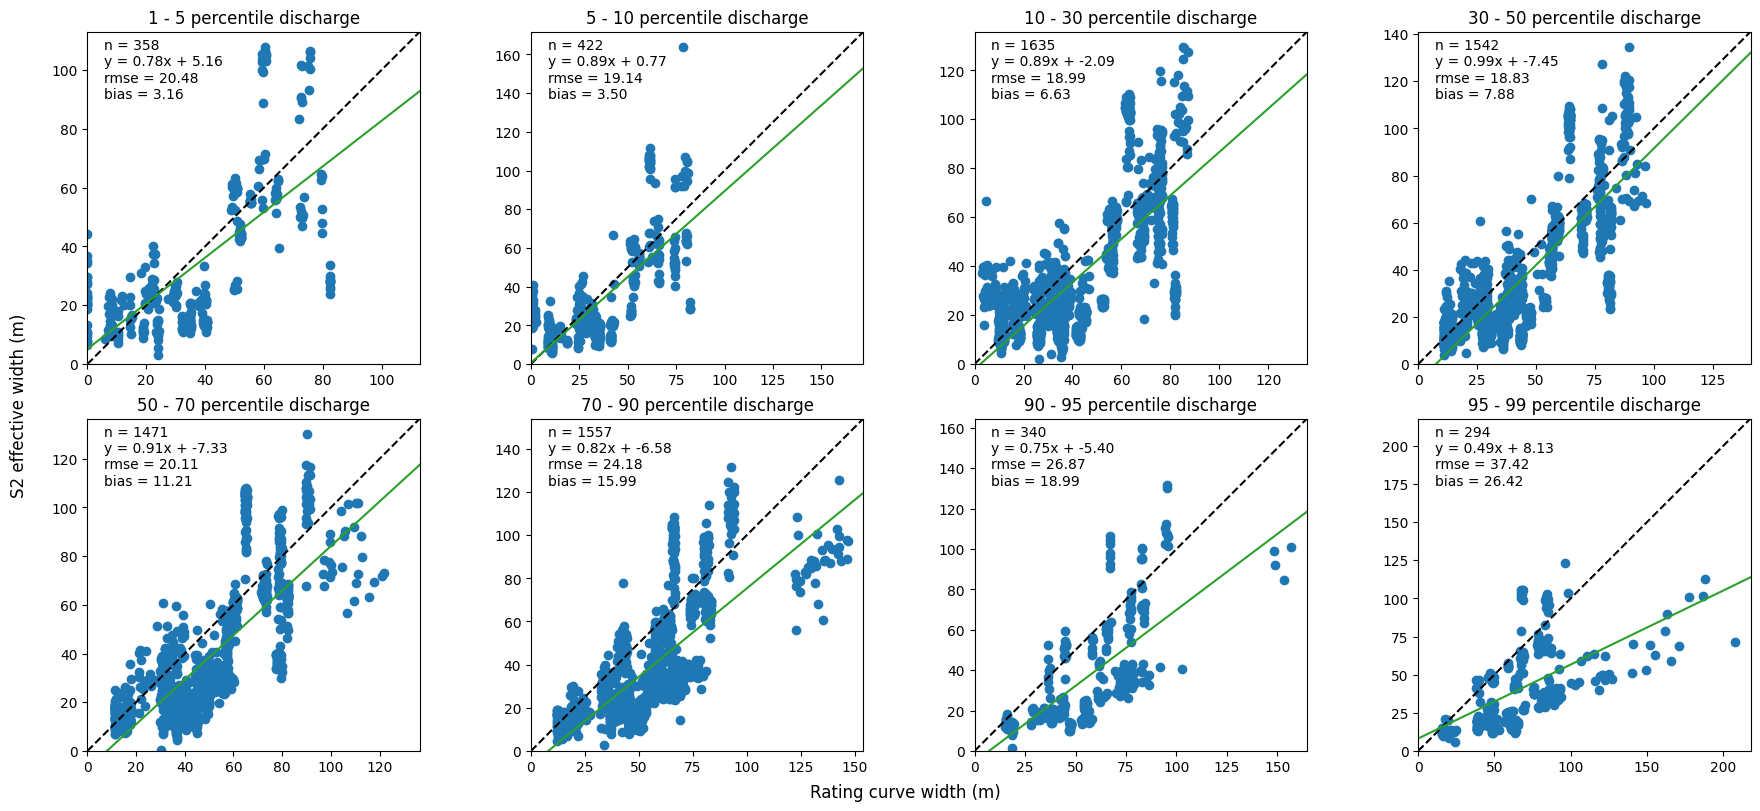

In [40]:
fig, axs = plt.subplots(2, 4, figsize=(18, 8), constrained_layout=True)
# nobridge_wQ = wQ.loc[wQ.index.get_level_values('site_no').isin(nobridge)]
# paired_Qw['color'] = paired_Qw.index.get_level_values('site_no').map(cs)
biases = []
rmses = []
r2s = []

n = 3
g = gage_list[n]
for i in range(len(bins) - 1):

    ax = axs.flatten()[i]
    df = all_joined.loc[(np.isfinite(all_joined.predicted_width)) & (all_joined.Q_percentile_bin == i)].reset_index()
    df = df.loc[df.site_no != '06799350'] # omit for lakes beside river
    df = df.loc[df.site_no != '06799000'] # omit for persistent bridge effect, good mask otherwise
    df = df.loc[df.site_no != '06770200'] # omit for extreme braiding
    # df = df.loc[df.site_no != '06652000'] # omit for negative b exponent
    # df = df.loc[df.site_no != '06775900'] # omit for negative b exponent
    df = df.loc[(df.predicted_width >= 0) & (df.mean_width >= 0)]
    # df2 = df.loc[(df.chan_width >= 0) & (df.mean_width >= 0)]
    df2 = df.loc[df.site_no == g]

    upper = 1.05 * max(df.mean_width.max(), df.predicted_width.max())

    slope, intercept, r, pval, _ = linregress(df.predicted_width, df.mean_width)
    errors = df.predicted_width - df.mean_width
    bias = np.mean(errors)
    mse = mean_squared_error(df.predicted_width, df.mean_width)
    rmse = np.sqrt(mse)
    r2 = r2_score(df.predicted_width, df.mean_width)

    ax.scatter(df.predicted_width, df.mean_width)
    # ax.scatter(df.chan_width, df.mean_width, c='tab:orange')
    waxis = np.linspace(0, upper)
    ax.plot(waxis, waxis, c='black', ls='--')
    ax.plot(waxis, waxis * slope + intercept, c='tab:green')
    ax.set_title(f'{int(100 * bins[i])} - {int(100 * bins[i + 1])} percentile discharge')

    ax.text(0.05, 0.8, f'n = {len(df)}\ny = {slope:.2f}x + {intercept:.2f}\nrmse = {rmse:.2f}\nbias = {bias:.2f}', transform=ax.transAxes)
    ax.set_aspect('equal')
    ax.set_xlim(0, upper)
    ax.set_ylim(0, upper)

    r2s.append(r2)
    biases.append(bias)
    rmses.append(rmse)

fig.supxlabel('Rating curve width (m)')
fig.supylabel('S2 effective width (m)')
# fig.suptitle(g)


print('mean rmse =', np.array(rmses).mean())
print('mean bias =', np.array([abs(b) for b in biases]).mean())
print('mean r2 =', np.array(r2s).mean())
print('\n')
print('mean rmse 10-90% =', np.array(rmses[1:9]).mean())
print('mean bias 10-90% =', np.array([abs(b) for b in biases[1:9]]).mean())
print('mean r2 10-90% =', np.array(r2s[1:9]).mean())

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
ew_pts

NameError: name 'states' is not defined

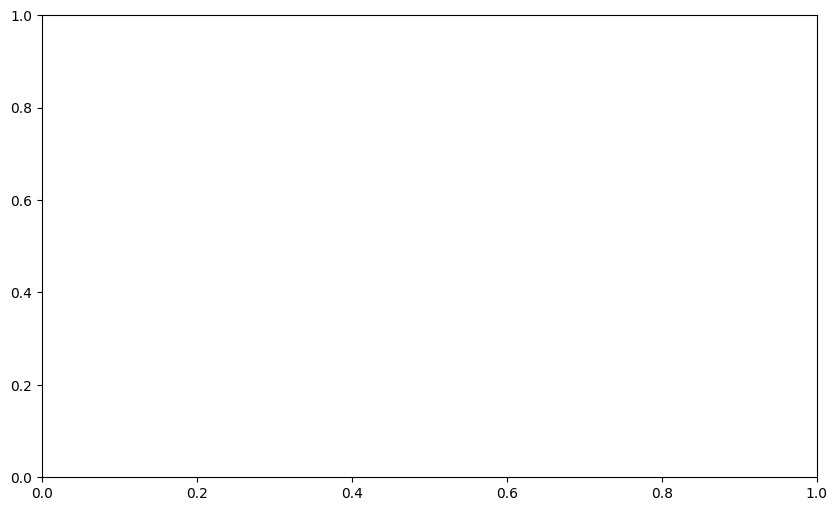

In [41]:
clm = cb_centerlines.to_crs(5070)

l, b, r, t = clm.total_bounds

gage_map, ax = plt.subplots(figsize=(10, 6))

states.plot(ax=ax, facecolor='none', edgecolor='tab:gray', linewidth=0.4, zorder=1)
clm.plot(ax=ax, color='tab:blue', zorder=2, linewidth=0.8)

gQ = gs.plot(ax=ax, column='median_Q', cmap='viridis', zorder=4, legend=False, markersize=10, marker='^')
ew_pts.to_crs(5070).plot(ax=ax, zorder=3, legend=True, markersize=5, color='gray')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=50))
sm.set_array([])


divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='10%', pad=0.1)
plt.colorbar(sm, label=r'Median Discharge ($m^{3}s^{-1}$)', cax=cbar_ax, orientation='horizontal')

ax.set_xlim((l - (r - l) / 8), (r + (r - l) / 8))
ax.set_ylim((b - (t - b) / 8), (t + (t - b) / 8))

ax.set_xticks([])
ax.set_yticks([])

shape_handles = []
shape_labels = ['Width Measurement Site', 'Gage']
for marker, label, sz in zip(['o', '^'], shape_labels, [5, 10]):
    shape_handles.append(plt.scatter([], [], s=sz, marker=marker, color='gray', label=label))


ax.legend(handles = shape_handles, labels=shape_labels, loc='upper right')

# fig.savefig('/content/drive/MyDrive/Platte_gage_map_hires_20250929.png', dpi=600, bbox_inches='tight')

In [ ]:
sn = '06759500'
a = rating_curve_parms.loc[sn, 'a']
b = rating_curve_parms.loc[sn, 'b']
rc_fig_df = all_joined.loc[all_joined.site_no == sn].sort_values('Q_cms')
rc_example, ax = plt.subplots(figsize=(6, 6))
ax.scatter(rc_fig_df.Q_cms, rc_fig_df.chan_width, label='In-situ width')
ax.plot(rc_fig_df.Q_cms, a * rc_fig_df.Q_cms ** b, c='black', ls='--', label='Rating Curve')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_xlabel(r'Discharge ($m^{3}s^{-1}$)')
ax.set_ylabel(r'Width ($m$)')
ax.set_aspect('equal')
# handles = [']
# ax.legend()
# ax.text(40, 175, fr'$w = {a:.2f}Q^{{{b:.2f}}}$')



In [ ]:
from pysheds.grid import Grid
grid = Grid.from_raster(r'c:\Users\dego\Downloads\rasters_USGS1m(2)\stroubles_poverty_dem.tif')
dem = grid.read_raster(r'c:\Users\dego\Downloads\rasters_USGS1m(2)\stroubles_poverty_dem.tif')

filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
acc = grid.accumulation(fdir, dirmap=dirmap)

In [ ]:
rasterio

In [ ]:
import rasterio as rio
with rio.open(r'c:\Users\dego\Downloads\rasters_USGS1m(2)\stroubles_poverty_dem.tif') as src:
    meta = src.meta


meta

In [ ]:
inflated_dem.values

In [ ]:
with rio.open(r'c:\Users\dego\Downloads\rasters_USGS1m(2)\fdir.tif', 'w', **meta) as dst:
    dst.write(fdir, 1)

with rio.open(r'c:\Users\dego\Downloads\rasters_USGS1m(2)\acc.tif', 'w', **meta) as dst:
    dst.write(acc, 1)

In [ ]:
tdf = all_joined.loc[(all_joined.site_no == g) & (all_joined.predicted_width >= 0) & (all_joined.mean_width >= 0)]
tdf


In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=tdf.predicted_width,
        y=tdf.mean_width, 
        mode='markers', 
        hoverinfo='text', 
        hovertemplate=tdf.date,
        marker=dict(
            color=df.Q_percentile_bin
        )
    )
)
fig.update_layout(
    yaxis_scaleanchor="x",
    yaxis_scaleratio=1,
    width=600,
    height=600,
    xaxis=dict(range=[0, max(tdf.predicted_width.max(), tdf.chan_width.max())]),
    yaxis=dict(range=[0, max(tdf.predicted_width.max(), tdf.chan_width.max())])
)

In [ ]:
c = ew_circles.loc[ew_circles.iindex == 57498]
cl = gpd.sjoin(cb_centerlines, c)
mcl = gpd.sjoin_nearest(merit_centerlines, c, max_distance=100)
fig, ax = plt.subplots()
c.plot(ax=ax)
cl.plot(ax=ax, color='tab:orange')
# mcl.plot(ax=ax, color='tab:green')
# ax.set_xlim(-1.13078 * 1e7, -1.1307 * 1e7)

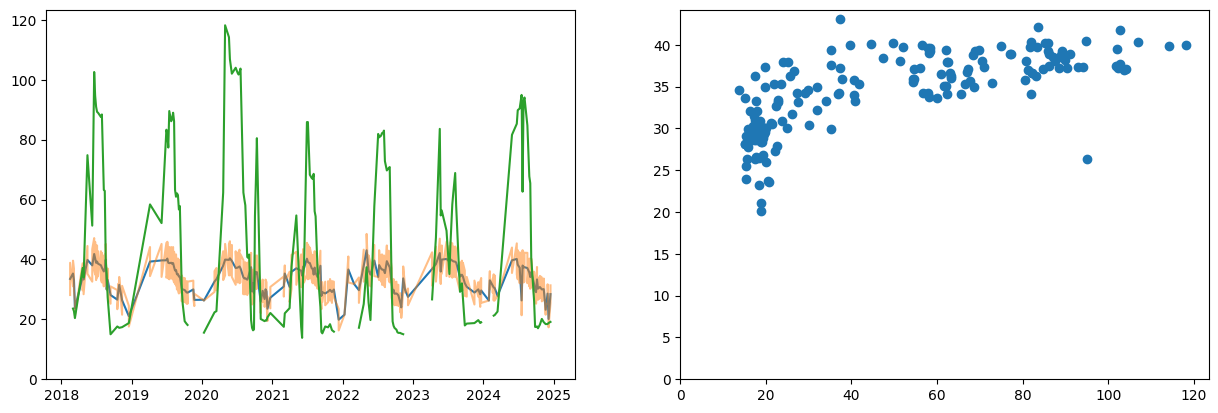

In [42]:
g = gage_list[32]
poop = all_joined.loc[all_joined.site_no == g].sort_values('date')
poop1 = gage_COMID_ew_filtered.loc[gage_COMID_ew_filtered.site_no == g].sort_values('date')
poop = poop.loc[poop.mean_width >= 0]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(poop.date, poop.mean_width)
ax1.plot(poop1.date, poop1.sat_width_m, alpha=0.5)
ax1.plot(poop.date, poop.Q_cms)
ax1.set_ylim(0)

ax2.scatter(poop.Q_cms, poop.mean_width)
ax2.set_ylim(0)
ax2.set_xlim(0)

fig.set_figwidth(15)

In [ ]:
all_joined_no0 = all_joined.copy()
all_joined_no0 = all_joined_no0.loc[(all_joined_no0.Q_cms > 0) & (all_joined_no0.mean_width > 0)]
all_joined_no0['logQ'] = np.log10(all_joined_no0.Q_cms)
all_joined_no0['logw'] = np.log10(all_joined_no0.mean_width)

all_joined_no0

In [ ]:
sat_b = []
sat_loga = []
sat_nmeas = []
sat_r2 = []
sns = []
minQ = []
maxQ = []
for sn, df in all_joined_no0.groupby('site_no'):

    if len(df) > 5:
        slope, intercept, r, _, _ = linregress(df.logQ, df.logw)
        sat_b.append(slope)
        sat_loga.append(intercept)
        sat_r2.append(r ** 2)
        sat_nmeas.append(len(df))
        sns.append(sn)
        minQ.append(df.Q_cms.min())
        maxQ.append(df.Q_cms.max())
    
    else:
        sat_b.append(None)
        sat_loga.append(None)
        sat_r2.append(None)
        sat_nmeas.append(len(df))
        sns.append(sn)
        minQ.append(None)
        maxQ.append(None)

sat_rc_parms = pd.DataFrame({
    'site_no': sns,
    'sat_b': sat_b,
    'sat_loga': sat_loga,
    'sat_nmeas': sat_nmeas,
    'sat_r2': sat_r2,
    'min_Q': minQ,
    'max_Q': maxQ
})

sat_rc_parms['sat_a'] = 10 ** sat_rc_parms.sat_loga
sat_rc_parms = sat_rc_parms.loc[sat_rc_parms.sat_nmeas > 5]\
    .set_index('site_no')

In [ ]:
new_rcp = rating_curve_parms.loc[rating_curve_parms.n_meas > 0]

In [ ]:
all_rcp = new_rcp.join(sat_rc_parms)

all_rcp['bdiff'] = all_rcp.b - all_rcp.sat_b
all_rcp['adiff'] = all_rcp.a - all_rcp.sat_a

all_rcp = all_rcp.loc[~all_rcp.sat_loga.isna()]

In [ ]:
all_rcp.loc[g].min_Q

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(12, 16), constrained_layout=True)

gs = all_rcp.index
for i in range(len(gs)):
    ax = axs.flatten()[i]
    g = gs[i]
    df = all_rcp.loc[g]

    Q = np.linspace(df.min_Q, df.max_Q)
    ax.plot(Q, df.a * (Q ** df.b))
    ax.plot(Q, df.sat_a * (Q ** df.sat_b))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(g)
